# Решение задачи кредитного скоро из первого задания курса Data Analysis на Курсере

Эту задачу предлагали в качестве домашнего задания в рамках курса Data Analysis на Coursera.

Описание переменных находятся в <a href="https://spark-public.s3.amazonaws.com/dataanalysis/loansCodebook.pdf">отдельном</a> файле.

Данные доступны в формате <a href="https://spark-public.s3.amazonaws.com/dataanalysis/loansData.csv">.csv</a> и <a href="https://spark-
public.s3.amazonaws.com/dataanalysis/loansData.rda)">.rda</a>. 

В рамках курса предполагось использование R, мы же будем смотреть эти данные при помощи Pandas и Python.

Самое крутое, что суть задания была в том, чтобы научить людей проведение исследованию и правильному оформлению результатов. Предполагается использование шаблонов, содержащих определённую структуру проекта. Отдельное хранение данных, кода и текстового отчёта для создания воспроизводимого исследования (это когда любой желающий может скачать данные, код и самостоятельно убедиться в том, что все вычисления производятся верно).



## Введение

Предоставленные данные представляют собой статистику по займам p2p клуба.
При этом кредиторы имеют различный рейтинг в зависимости от их платёжеспособности, на основе которого и рассчитываются проценты по займу, а также максимальная сумма кредита. В общем случае, проценты по кредиту оказываются связаны с риском невозврата. Естественно, что люди с плохой кредитной историей будут получать больший процент, меньшую сумму и на меньший промежуток времени.

Мы будем анализировать данные 2500 займов, вся информация по которым приведена в исходных данных.

Целью исследования является определение тех факторов, которые оказывают влияние на принятие решения о выделении займа или в отказе на него.

## Исследование

### Данные

Как всегда, сначала загрузим нужные модули и настроим графики так, чтобы они были милыми и аккуратными.

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas import date_range,Series,DataFrame,read_csv, qcut
from pandas.tools.plotting import radviz,scatter_matrix,bootstrap_plot,parallel_coordinates
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from numpy.random import randn
from pylab import *
import brewer2mpl
from matplotlib import rcParams

#colorbrewer2 Dark2 qualitative color table
dark2_colors = brewer2mpl.get_map('Dark2', 'Qualitative', 7).mpl_colors

rcParams['figure.figsize'] = (10, 6)
rcParams['figure.dpi'] = 150
rcParams['axes.color_cycle'] = dark2_colors #axes.color_cycle
rcParams['lines.linewidth'] = 2
rcParams['axes.facecolor'] = 'white'
rcParams['font.size'] = 14
rcParams['patch.edgecolor'] = 'white'
rcParams['patch.facecolor'] = dark2_colors[0]
rcParams['font.family'] = 'StixGeneral'

def remove_border(axes=None, top=False, right=False, left=True, bottom=True):
    """
    Minimize chartjunk by stripping out unnecesasry plot borders and axis ticks
    
    The top/right/left/bottom keywords toggle whether the corresponding plot border is drawn
    """
    ax = axes or plt.gca()
    ax.spines['top'].set_visible(top)
    ax.spines['right'].set_visible(right)
    ax.spines['left'].set_visible(left)
    ax.spines['bottom'].set_visible(bottom)
    
    #turn off all ticks
    ax.yaxis.set_ticks_position('none')
    ax.xaxis.set_ticks_position('none')
    
    #now re-enable visibles
    if top:
        ax.xaxis.tick_top()
    if bottom:
        ax.xaxis.tick_bottom()
    if left:
        ax.yaxis.tick_left()
    if right:
        ax.yaxis.tick_right()

C:\Users\iskus\Anaconda3\lib\site-packages\matplotlib\__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [8]:
data = pd.read_csv('loansData.csv', delimiter=',').dropna()

Посмотрим, как с чем мы имеем дело.

In [9]:
data.head()

,Amount.Requested,Amount.Funded.By.Investors,Interest.Rate,Loan.Length,Loan.Purpose,Debt.To.Income.Ratio,State,Home.Ownership,Monthly.Income,FICO.Range,Open.CREDIT.Lines,Revolving.CREDIT.Balance,Inquiries.in.the.Last.6.Months,Employment.Length
81174,20000,20000.0,8.90%,36 months,debt_consolidation,14.90%,SC,MORTGAGE,6541.67,735-739,14.0,14272.0,2.0,< 1 year
99592,19200,19200.0,12.12%,36 months,debt_consolidation,28.36%,TX,MORTGAGE,4583.33,715-719,12.0,11140.0,1.0,2 years
80059,35000,35000.0,21.98%,60 months,debt_consolidation,23.81%,CA,MORTGAGE,11500.00,690-694,14.0,21977.0,1.0,2 years
15825,10000,9975.0,9.99%,36 months,debt_consolidation,14.30%,KS,MORTGAGE,3833.33,695-699,10.0,9346.0,0.0,5 years
33182,12000,12000.0,11.71%,36 months,credit_card,18.78%,NJ,RENT,3195.00,695-699,11.0,14469.0,0.0,9 years


Мы имеем дело с 14 переменными, которые задают запрашиваемую сумму, выданный займ, проценты по нему, длительность займа, цель, штат заёмщика, его месячный доход, количество запросов на кредит в течение последних 6 месяцев, стаж работы, а также кредитный рейтинг.

### Очистка и нормализация данных

Когда мы считали данные, мы сразу указали параметр, который отбросил данные не имеющие какой-то переменной, поэтому у нас осталось:

In [10]:
len(data)

2498

2498 случаев займа. Теперь нужно привести к численному виду кредитный рейтинг заёмщика, который в оргинальном наборе представляет собой промежуток. Как сказали бы математики, не нарушая общности рассуждений (что значит, ткнув пальцем в небо), возьмём в качестве значения нижнюю границу рейтинга.

In [11]:
clean_fico = [int(r.split('-')[0]) for r in data["FICO.Range"]]

In [12]:
data["FICO"] = clean_fico
data["FICO"].head()

81174    735
99592    715
80059    690
15825    695
33182    695
Name: FICO, dtype: int64

Теперь переведём в числовую переменную длительность займа, отношение запрашиваемой сумму к месячному доходу и процентную ставку:

In [13]:
loan_length = [int(r.split()[0]) for r in data["Loan.Length"]]
data["loan_length"] = loan_length
interest_rate = [float(r[:-1]) for r in data["Interest.Rate"]]
data["interest_rate"] = interest_rate 
debt_to_income_ratio = [float(r[:-1]) for r in data["Debt.To.Income.Ratio"]]
data["debt_to_income_ratio"] = debt_to_income_ratio
data[["debt_to_income_ratio","interest_rate","loan_length"]].head()


,debt_to_income_ratio,interest_rate,loan_length
81174,14.90,8.90,36
99592,28.36,12.12,36
80059,23.81,21.98,60
15825,14.30,9.99,36
33182,18.78,11.71,36


Ещё мы столкнёмся с проблемой в том, что в именах переменных сейчас стоят точки. Это очень легко исправить.

In [15]:
for item in data.columns:
    print("'"+item+"':'"+item.replace('.','_')+"',",)

'Amount.Requested':'Amount_Requested',
'Amount.Funded.By.Investors':'Amount_Funded_By_Investors',
'Interest.Rate':'Interest_Rate',
'Loan.Length':'Loan_Length',
'Loan.Purpose':'Loan_Purpose',
'Debt.To.Income.Ratio':'Debt_To_Income_Ratio',
'State':'State',
'Home.Ownership':'Home_Ownership',
'Monthly.Income':'Monthly_Income',
'FICO.Range':'FICO_Range',
'Open.CREDIT.Lines':'Open_CREDIT_Lines',
'Revolving.CREDIT.Balance':'Revolving_CREDIT_Balance',
'Inquiries.in.the.Last.6.Months':'Inquiries_in_the_Last_6_Months',
'Employment.Length':'Employment_Length',
'FICO':'FICO',
'loan_length':'loan_length',
'interest_rate':'interest_rate',
'debt_to_income_ratio':'debt_to_income_ratio',


In [16]:
data.rename(columns={'Amount.Requested':'Amount_Requested', \
                     'Amount.Funded.By.Investors':'Amount_Funded_By_Investors', \
                     'Interest.Rate':'Interest_Rate', 'Loan.Length':'Loan_Length', \
                     'Loan.Purpose':'Loan_Purpose', 'Debt.To.Income.Ratio':'Debt_To_Income_Ratio', \
                     'State':'State', 'Home.Ownership':'Home_Ownership', 'Monthly.Income':'Monthly_Income', \
                     'FICO.Range':'FICO_Range', 'Open.CREDIT.Lines':'Open_CREDIT_Lines', \
                     'Revolving.CREDIT.Balance':'Revolving_CREDIT_Balance', \
                     'Inquiries.in.the.Last.6.Months':'Inquiries_in_the_Last_6_Months', \
                     'Employment.Length':'Employment_Length'},inplace=True)

### Обзор данных

In [17]:
data.describe()

,Amount_Requested,Amount_Funded_By_Investors,Monthly_Income,Open_CREDIT_Lines,Revolving_CREDIT_Balance,Inquiries_in_the_Last_6_Months,FICO,loan_length,interest_rate,debt_to_income_ratio
count,2498.000000,2498.000000,2498.000000,2498.000000,2498.000000,2498.000000,2498.000000,2498.000000,2498.000000,2498.000000
mean,12413.030424,12009.280661,5685.203911,10.075661,15244.559648,0.906325,705.858687,41.265012,13.070368,15.385420
std,7801.222483,7743.387861,3959.527984,4.508644,18308.549795,1.231036,34.994039,9.933753,4.178007,7.501673
min,1000.000000,-0.010000,588.500000,2.000000,0.000000,0.000000,640.000000,36.000000,5.420000,0.000000
25%,6000.000000,6000.000000,3500.000000,7.000000,5585.750000,0.000000,680.000000,36.000000,10.160000,9.750000
50%,10000.000000,10000.000000,5000.000000,9.000000,10962.000000,0.000000,700.000000,36.000000,13.110000,15.320000
75%,17000.000000,16000.000000,6800.000000,13.000000,18888.750000,1.000000,725.000000,36.000000,15.800000,20.677500
max,35000.000000,35000.000000,102750.000000,38.000000,270800.000000,9.000000,830.000000,60.000000,24.890000,34.910000


Проверим корреляцию

In [18]:
data.corr()

,Amount_Requested,Amount_Funded_By_Investors,Monthly_Income,Open_CREDIT_Lines,Revolving_CREDIT_Balance,Inquiries_in_the_Last_6_Months,FICO,loan_length,interest_rate,debt_to_income_ratio
Amount_Requested,1.000000,0.969841,0.391179,0.195942,0.293365,-0.029561,0.083378,0.412298,0.331831,0.081288
Amount_Funded_By_Investors,0.969841,1.000000,0.374377,0.185826,0.261892,-0.067757,0.074284,0.406218,0.336830,0.093679
Monthly_Income,0.391179,0.374377,1.000000,0.171396,0.359684,0.033948,0.122714,0.074545,0.012921,-0.162345
Open_CREDIT_Lines,0.195942,0.185826,0.171396,1.000000,0.290085,0.110736,-0.089443,0.040890,0.090307,0.370850
Revolving_CREDIT_Balance,0.293365,0.261892,0.359684,0.290085,1.000000,0.012186,0.002917,0.055436,0.061109,0.189221
Inquiries_in_the_Last_6_Months,-0.029561,-0.067757,0.033948,0.110736,0.012186,1.000000,-0.092165,0.023842,0.164646,0.011979
FICO,0.083378,0.074284,0.122714,-0.089443,0.002917,-0.092165,1.000000,0.012703,-0.709216,-0.216963
loan_length,0.412298,0.406218,0.074545,0.040890,0.055436,0.023842,0.012703,1.000000,0.423506,0.024991
interest_rate,0.331831,0.336830,0.012921,0.090307,0.061109,0.164646,-0.709216,0.423506,1.000000,0.172203
debt_to_income_ratio,0.081288,0.093679,-0.162345,0.370850,0.189221,0.011979,-0.216963,0.024991,0.172203,1.000000


Единственное, что толкового можно понять из сводных данных, так это то, что большинство хотят занять деньги на 3 года. Сильно заметной корреляции между FICO и месячным доходом также нет. Строим графики, чтобы разобраться получше.

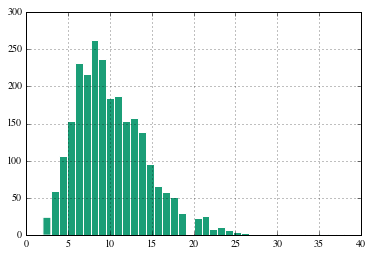

In [41]:
%matplotlib inline
plt.figure()
data["Open_CREDIT_Lines"].hist(bins=38)

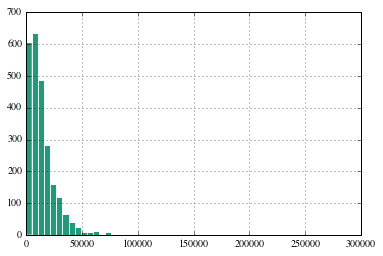

In [42]:
plt.figure()
data["Revolving_CREDIT_Balance"].hist(bins=50)

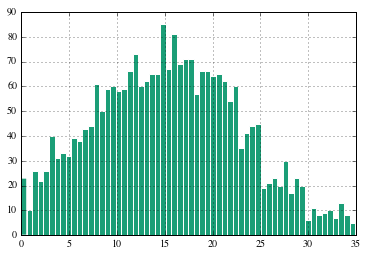

In [43]:
plt.figure()
data["debt_to_income_ratio"].hist(bins=60)

А сейчас мы построим график зависимости процента от кредитного рейтинга

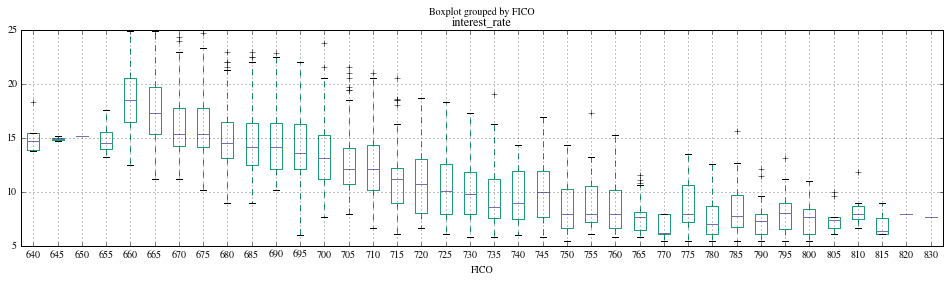

In [44]:
data.boxplot(column="interest_rate", by="FICO",figsize=(16,4));

На всякий случай сделаем факторную переменную:

In [45]:
data['FICO_Factor'] = pd.factorize(data['FICO_Range'])[0]

Логичная ситуация - чем меньше рейтинг, тем больше процент и его разброс. Надо проверить, оказывает ли он влияение на итоговый процент займа

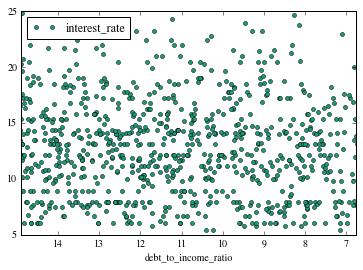

In [46]:
data.plot(x='debt_to_income_ratio', y='interest_rate', style='o', markersize=4);

In [47]:
formula = 'interest_rate ~ debt_to_income_ratio'
lm = ols(formula, data).fit()
print (anova_lm(lm))

                          df        sum_sq      mean_sq          F  \
debt_to_income_ratio     1.0   1292.519838  1292.519838  76.277803   
Residual              2496.0  42294.473223    16.944901        NaN   

                            PR(>F)  
debt_to_income_ratio  4.428487e-18  
Residual                       NaN  


Тут можно предположить, что % по займу будет расти вместе с ростом отношения запрашиваемой суммы к месячному доходу. А результаты проверки говорят, что так оно и есть.

А вот стаж на месте работы в Америке не особо влияет на займы:

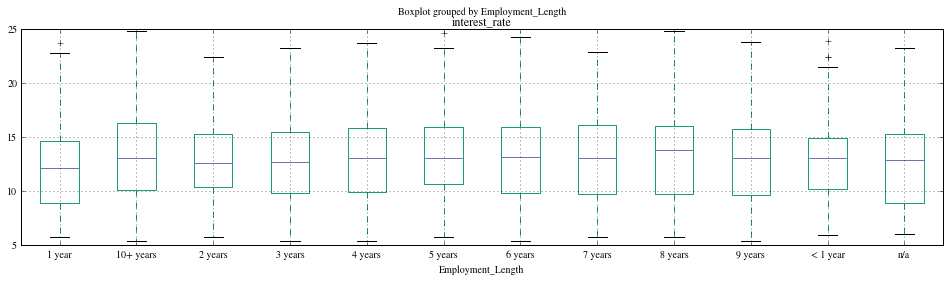

In [48]:
data.boxplot(column="interest_rate", by="Employment_Length",figsize=(16,4))

In [49]:
formula = 'interest_rate ~ C(Employment_Length)'
lm = ols(formula, data).fit()
anovaResults = anova_lm(lm)
print(anovaResults)

                          df        sum_sq    mean_sq         F    PR(>F)
C(Employment_Length)    11.0    183.916057  16.719642  0.957652  0.483354
Residual              2486.0  43403.077004  17.459001       NaN       NaN


Теперь такой же графики для цели займа:

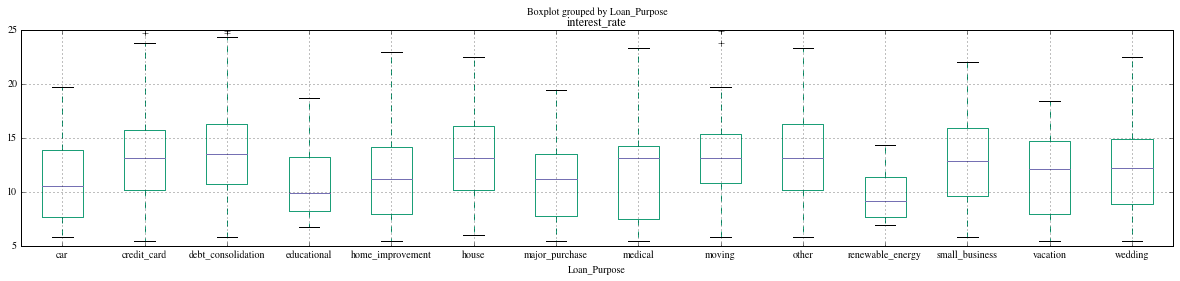

In [50]:
data.boxplot(column="interest_rate", by="Loan_Purpose",figsize=(20,4))

Ура. Ещё одна переменная, которая влияет на процент

In [51]:
formula = 'interest_rate ~ C(Loan_Purpose)'
lm = ols(formula, data).fit()
anovaResults = anova_lm(lm)
print(anovaResults)
  

                     df        sum_sq     mean_sq         F        PR(>F)
C(Loan_Purpose)    13.0   1630.161027  125.397002  7.423967  1.608494e-14
Residual         2484.0  41956.832034   16.890834       NaN           NaN


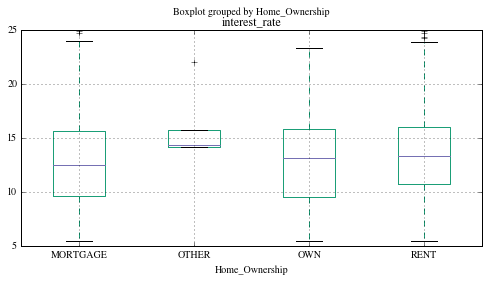

In [52]:
data.boxplot(column="interest_rate", by="Home_Ownership",figsize=(8,4))

In [53]:
formula = 'interest_rate ~ C(Home_Ownership)'
lm = ols(formula, data).fit()
anovaResults = anova_lm(lm)
print(anovaResults)

                       df        sum_sq     mean_sq         F    PR(>F)
C(Home_Ownership)     3.0    310.900041  103.633347  5.972387  0.000471
Residual           2494.0  43276.093020   17.352082       NaN       NaN


Построим гистограмму месячного дохода

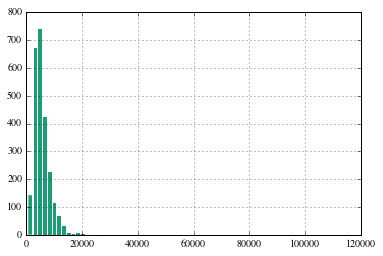

In [54]:
plt.figure()
data["Monthly_Income"].hist(bins=60)

Не слишком информативно. Попробуем перейти к логарифмической шкале.

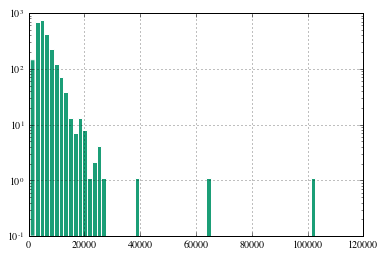

In [55]:
fig, ax = plt.subplots()
data["Monthly_Income"].hist(ax=ax, bins=60, bottom=0.1)
ax.set_yscale('log')

Получается что у нас есть статистические выбросы. Построим график зависимости процента от дохода без них:

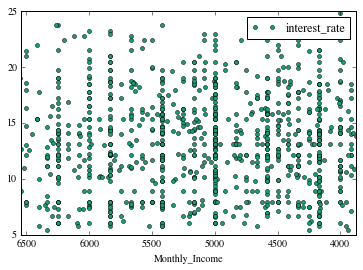

In [56]:
data[data["Monthly_Income"] < 30000].plot(x='Monthly_Income', y='interest_rate', style='o', markersize=4);

Пора проверить статистическую значимость:

In [57]:
formula = 'interest_rate ~ Monthly_Income'
lm = ols(formula, data).fit()
print (anova_lm(lm))

                    df        sum_sq    mean_sq        F    PR(>F)
Monthly_Income     1.0      7.277085   7.277085  0.41679  0.518602
Residual        2496.0  43579.715976  17.459822      NaN       NaN


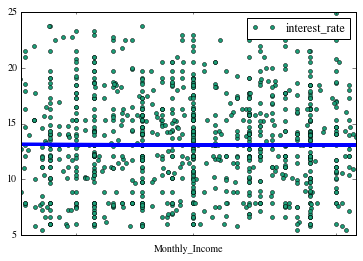

In [58]:
fig, ax = plt.subplots()
data[data["Monthly_Income"] < 30000].plot(ax=ax,x='Monthly_Income', y='interest_rate', style='o', markersize=4);
plt.plot(data['Monthly_Income'],lm.fittedvalues,'b');
ax.set_xscale('log')

Теперь посмотрим на график процента в зависимости от запрощенной суммы

In [59]:
formula = 'interest_rate ~ Amount_Requested'
lm = ols(formula, data).fit()
print (anova_lm(lm))

                      df        sum_sq      mean_sq           F        PR(>F)
Amount_Requested     1.0   4799.447651  4799.447651  308.847111  2.828310e-65
Residual          2496.0  38787.545411    15.539882         NaN           NaN


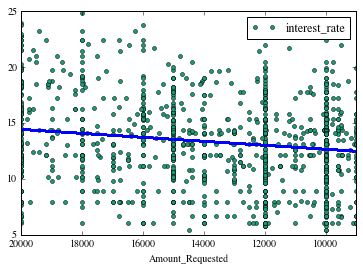

In [60]:
plt.figure()
data.plot(x='Amount_Requested', y='interest_rate', style='o', markersize=4);
plt.plot(data['Amount_Requested'],lm.fittedvalues,'b');

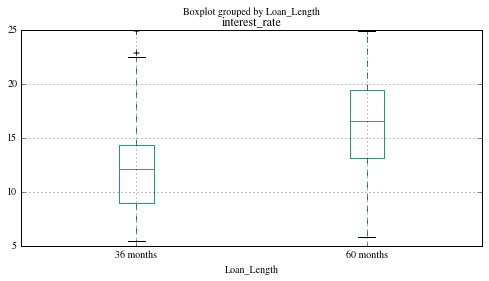

In [61]:
data.boxplot(column="interest_rate", by="Loan_Length",figsize=(8,4))

In [62]:
formula = 'interest_rate ~ C(Loan_Purpose) + Monthly_Income + FICO + debt_to_income_ratio + Amount_Requested + Loan_Length'
lm = ols(formula, data).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:          interest_rate   R-squared:                       0.753
Model:                            OLS   Adj. R-squared:                  0.751
Method:                 Least Squares   F-statistic:                     418.8
Date:                Wed, 01 Jun 2016   Prob (F-statistic):               0.00
Time:                        13:31:44   Log-Likelihood:                -5371.5
No. Observations:                2498   AIC:                         1.078e+04
Df Residuals:                    2479   BIC:                         1.089e+04
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------------------------

Вот и отлично. Судя по тому, что R-squared равен 0.75, мы смогли объяснить 75% дисперсии исходных данных. Добавление другие переменных значимого улучшения модели не дало. Можно было заморочиться и добавить в модель комбинации факторов, но это тоже не приведёт к улучшению качества.